In [1]:
import spacy
import csv
import pandas as pd
import json
import requests
import geopandas
from geodatasets import get_path
import matplotlib.pyplot as plt
import folium


In [7]:
import folium

initial entity extraction with spacy, using 2 files as spacy has word limits

In [10]:
with open('agatha2.txt', 'r', encoding='utf-8') as file:
    content2 = file.read()

In [ ]:
entities = list()
nlp = spacy.load("en_core_web_sm")
doc = nlp(content)
for entity in doc.ents:
     if entity.label_ in ["FAC", "GPE", "LOC", "ORG"]:
          entities.append(entity)
          print(entity)

In [11]:
doc2 = nlp(content2)

In [12]:
for entity in doc2.ents:
     if entity.label_ in ["FAC", "GPE", "LOC", "ORG"]:
          entities.append(entity)
len(entities)

2627

In [13]:
with open('ents.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(entities)

matching using api query

In [43]:
def getcoords(label):
    coords = None
    try:
        site = pywikibot.Site("en", "wikipedia")
        page = pywikibot.Page(site, label)
        item = pywikibot.ItemPage.fromPage(page) 
        item_dict = item.get()  
        claims = item_dict["claims"] 
        if 'P625' in claims:
            cc = claims['P625']
            for clm in cc:
                coords = clm.getTarget()
    except:
        print("not found")
    return(coords)

In [ ]:
with open('agplaces.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        coords = getcoords(row['Name'])
        print(row['Name'],type(row['Name']))


In [ ]:
with open('places.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'coords']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    with open('agplaces.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            label = row['Name']
            coords = getcoords(label)
            writer.writerow({'label': label, 'coords': coords}) 

In [ ]:
# using api query

In [ ]:
query = '''SELECT distinct ?item ?itemLabel ?itemDescription ?coords WHERE{  
  ?item ?label "'''
query2 = '''"@en.   
  ?article schema:about ?item .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }   
  OPTIONAL {
        ?item wdt:P625 ?coords .
    }
}'''
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'

In [ ]:

data = requests.get(url, params={'query': query+'Alexandretta'+query2, 'format': 'json'}).json()

In [69]:
for item in data['results']['bindings']:
    if 'coords' in item:
        print(item['item']['value'], item['itemLabel']['value'], item['itemDescription']['value'], item['coords']['value'])

http://www.wikidata.org/entity/Q174341 İskenderun district and city in Hatay, Turkey Point(36.173333333 36.587222222)


In [ ]:
agplacedf = pd.DataFrame(columns=['wid', 'name', 'label', 'description', 'coords']) 

with open('agplaces.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        name = row['Name']
        try:
            data = requests.get(url, params={'query': query+name+query2, 'format': 'json'}).json()
            for item in data['results']['bindings']:
                if 'coords' in item:
                    wid = item['item']['value'].replace('http://www.wikidata.org/entity/','')
                    new_row = {'wid':wid, 'name': name, 'label': item['itemLabel']['value'], 'description': item['itemDescription']['value'], 'coords':item['coords']['value']}
                    agplacedf = agplacedf._append(new_row, ignore_index=True)
                    print('found',new_row)
        except:
            print('item not found',name)        


In [82]:
agplacedf.to_csv('wikiq.csv', index=False)

In [ ]:
gdf = geopandas.GeoDataFrame(agplacedf, geometry="coords")
gdf.head()

In [ ]:
# mapping

In [2]:
tdf = pd.read_csv('agquotes.csv', encoding='latin')
tdf.head()

,name,label,Acswords,long,lat
0,Newton Abbot,Newton Abbot,A deputy of Mrs Wordsworth started a dancing e...,-3.608700,50.540300
1,East Croydon railway station,East Croydon railway station,"Among our other activities at the weekend, Arc...",-0.092300,51.375200
2,Nippur,Nippur,"I enjoyed the day at Nippur very much, though ...",45.230833,32.126111
3,Mersin,Mersin,I remember best going ashore with Max at Mersi...,34.616667,36.800000
4,Banbury,Banbury,I remember one day we made an excursion to Ban...,-1.339167,52.061389


In [6]:
tdf=tdf.rename(columns = {'Acswords':'Agatha writes'})
tgdf = geopandas.GeoDataFrame(
    tdf, geometry=geopandas.points_from_xy(tdf.long, tdf.lat), crs="EPSG:4326"
)
tgdf.head()

,name,label,Agatha writes,long,lat,geometry
0,Newton Abbot,Newton Abbot,A deputy of Mrs Wordsworth started a dancing e...,-3.608700,50.540300,POINT (-3.6087 50.5403)
1,East Croydon railway station,East Croydon railway station,"Among our other activities at the weekend, Arc...",-0.092300,51.375200,POINT (-0.0923 51.3752)
2,Nippur,Nippur,"I enjoyed the day at Nippur very much, though ...",45.230833,32.126111,POINT (45.23083 32.12611)
3,Mersin,Mersin,I remember best going ashore with Max at Mersi...,34.616667,36.800000,POINT (34.61667 36.8)
4,Banbury,Banbury,I remember one day we made an excursion to Ban...,-1.339167,52.061389,POINT (-1.33917 52.06139)


In [7]:
tgjson = tgdf.to_json()

In [36]:
tgjson

'{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"name": "Newton Abbot", "label": "Newton Abbot", "Acswords": "A deputy of Mrs Wordsworth started a dancing evening for adults at Newton Abbot, and I and others used to go over for instruction. There I made what I called \\u0091my Tango friend\\u0092\\u0096a young man whose Christian name was Ronald and whose last name I cannot remember. We rarely spoke to each other or took the least interest in each other\\u0096our whole mind was engrossed with our feet.", "long": -3.6087, "lat": 50.5403}, "geometry": {"type": "Point", "coordinates": [-3.6087, 50.5403]}}, {"id": "1", "type": "Feature", "properties": {"name": "East Croydon railway station", "label": "East Croydon railway station", "Acswords": "Among our other activities at the weekend, Archie and I sometimes went by train to East Croydon and played golf there. I had never been much of a golfer, and Archie had played little, but he became keenly ap

In [8]:
m = folium.Map(location=(-0.20932, 51.5025), zoom_control=False)

geojson = folium.GeoJson(
    tgjson,
    style_function=lambda feature: {
        "weight": 1,
        "color": "#fcfcfc",
        "fillOpacity": 0.8,
        "fillColor":  "#020202"
    },
).add_to(m)

m

In [10]:
map = folium.Map(location=[51.5025, -0.20932], tiles = 'cartodbpositron', zoom_start=4
                 , control_scale=True)
folium.features.GeoJson(tgjson, name="Agatha's Places", popup=folium.features.GeoJsonPopup(fields=['name','Agatha writes'])).add_to(map)
map

In [11]:
map.save("agathamap.html")

<Axes: >

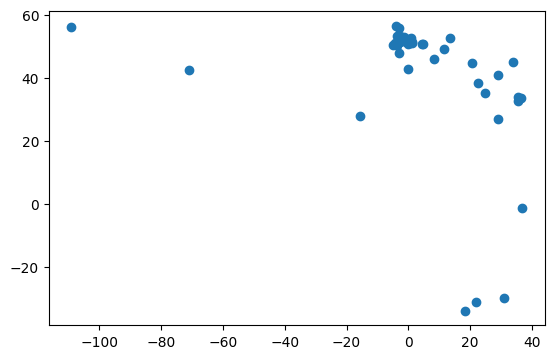

In [101]:
tgdf.plot()